# Contexte du projet

Vous travaillez dans une startup edtech qui offre des services de vulgarisation de l'IA. Votre client
souhaite avoir un outil de démo pour expliquer comment ça fonctionne un réseau de neurones.
 
<b>1.</b>
Votre premier objectif est de créer un modèle de deep learning pour classifier des chiffres.

<b>2.</b>
Ensuite, vous devez développer l'interface utilisateur (avec streamlit) qui vous permet de
déssiner un chiffre (ou choisir aléatoirement un numéro d'un dataset d'images) et de détecter s'il
correspond à une chiffre entre 0 & 9.

source image : https://www.mdpi.com/2076-3417/9/15/3169
 
Pour l'interface utilisateur, votre première version streamlit doit être capable de montrer une
image aléatoire du dataset test. Ensuite, grâce à un bouton "predict", votre modèle peut prédire
le bon nombre et afficher le résultat dans l'interface. À la fin, l'interface doit vous permettre avec
un bouton de valider si votre modèle a correctement classé l'image ou non.
 
Dans un deuxièmet temps, vous pouvez faire évoluer votre interface comme un jeu. Dans cette
deuxième version, l'interface doit vous permettre de dessiner un nombre et le transformer en
image. Cette image va ensuite être utilisée par le modèle pour prédire le bon nombre et afficher
le résultat. L'idée derrière est de donner 10 opportunités à votre modèle de détecter le chiffre
dessiné et donner des stats à la fin par rapport à sa performance de prédiction.
 
Vous pouvez vous insprer de cette interface pour faire évoluer votre démo :
https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html

# Import

In [1]:
# classic
import pandas as pd
import numpy as np

# visu
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# RAdam
from keras_radam import RAdam

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Data

<b>Les données</b><br><br>
Import des données de training (train, avec la target 'label' qui contient les chiffres à reconnaître de 0 à 9) et des données de test.<br>

Le train_data contient 42 000 lignes et 785 colonnes<br>
Le train_test contient 28 000 lignes et 784 colonnes<br>

Chaque image a une taille de 28 x 28 px. Il n'y a aucun valeurs manquantes ou null.

In [2]:
# import csv
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [3]:
# visualisation train_data
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# nombre de valeurs manquantes dans les 2 datasets
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


In [5]:
# shape des data train et test
print(train_data.shape)
print(test_data.shape)

(42000, 785)
(28000, 784)


In [7]:
# chaque image a une taille de 28 x 28 px
image_size=28*28
image_size

784

In [8]:
# voir la valeur maximum dans le train_data
max_values = train_data.max(axis=1)
max_values

0        255
1        255
2        255
3        255
4        254
        ... 
41995    255
41996    254
41997    255
41998    255
41999    255
Length: 42000, dtype: int64

In [6]:
# définir X & Y sur le train_data
X = train_data.drop('label', axis=1)
y = train_data['label']

In [12]:
X.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [7]:
# Fonction pour afficher les données matricielles sous forme d'images
def visu_img(X, y, n, label=False):
    plt.figure(figsize=(20,2))
    for i in range(1):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X.values[i].reshape(28,28))
        if label:
            plt.title("Numero: {}".format(y[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

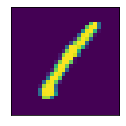

In [8]:
visu_img(X, y, n=1, label=False)

# Preprocessing

<b>Préparation des données</b><br><br>
Chacun des pixels a une valeur de 0 à 255, je vais normaliser les valeurs de 0 à 1, et reshape les données (784 colonnes) en matrice de 28 x 28 (taille des images en px).

In [9]:
# convertir les vecteurs en matrice de classe binaire (num_classes = 10 / les chiffres de 0 à 9)
y = to_categorical(y, num_classes=10)

In [10]:
# train and test split
X_train, X_test ,y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# normalisation des données
X_train, X_test = X_train / 255.0, X_test / 255.0

In [12]:
# reshape 28 x 28
X_train, X_test= X_train.values.reshape(-1,28,28,1), X_test.values.reshape(-1,28,28, 1)

In [13]:
# shape des data train et test
print(X_train.shape)
print(X_test.shape)

(29400, 28, 28, 1)
(12600, 28, 28, 1)


# Modèle CNN

- Hidden Layer: 4
- Types de layers : Con2D, MaxPooling2D, Flatten, Dense, Dropout
- Nodes: 142
- Fonctions d'activation : ReLU / Softmax en sortie
- Optimizer: RAdam
- Loss Function: Categorical crossentropy
- Epochs: 20
- Validation split : 0.3
- Early stopping : patience = 2

In [14]:
# early stopping (apply on .fit)
early_stopping_monitor=EarlyStopping(patience=2, restore_best_weights=True)

In [15]:
# model dl
model = Sequential()

# Conv2D : analyse des images et détection d'un ensemble de features
model.add(Conv2D(128, kernel_size=(3,3), input_shape=(28, 28, 1), padding='same', activation='relu'))

# MaxPooling2D : réduit la taille des images tout en préservant leurs caractéristiques
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# Flatten : conversion des matrices 3D en vecteur 1D
model.add(Flatten()) 

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1605696   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 1,607,626
Trainable params: 1,607,626
Non-trainable params: 0
______________________________________________

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.3, callbacks=[early_stopping_monitor])

Epoch 1/20
644/644 [==============================] - 38s 57ms/step - loss: 0.3028 - accuracy: 0.9096 - val_loss: 0.1193 - val_accuracy: 0.9642
Epoch 2/20
644/644 [==============================] - 35s 55ms/step - loss: 0.1069 - accuracy: 0.9674 - val_loss: 0.0780 - val_accuracy: 0.9770
Epoch 3/20
644/644 [==============================] - 37s 57ms/step - loss: 0.0727 - accuracy: 0.9771 - val_loss: 0.0742 - val_accuracy: 0.9768
Epoch 4/20
644/644 [==============================] - 36s 56ms/step - loss: 0.0527 - accuracy: 0.9831 - val_loss: 0.0668 - val_accuracy: 0.9806
Epoch 5/20
644/644 [==============================] - 38s 59ms/step - loss: 0.0442 - accuracy: 0.9855 - val_loss: 0.0668 - val_accuracy: 0.9797
Epoch 6/20
644/644 [==============================] - 37s 58ms/step - loss: 0.0346 - accuracy: 0.9891 - val_loss: 0.0686 - val_accuracy: 0.9799


In [21]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [22]:
# score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1242
           1       0.99      0.99      0.99      1452
           2       0.98      0.97      0.97      1271
           3       0.99      0.96      0.98      1244
           4       0.98      0.97      0.97      1215
           5       0.97      0.98      0.97      1138
           6       0.99      0.98      0.98      1235
           7       0.98      0.98      0.98      1278
           8       0.95      0.98      0.97      1230
           9       0.97      0.98      0.97      1295

    accuracy                           0.98     12600
   macro avg       0.98      0.98      0.98     12600
weighted avg       0.98      0.98      0.98     12600



Text(0.5, 15.0, 'Predicted label')

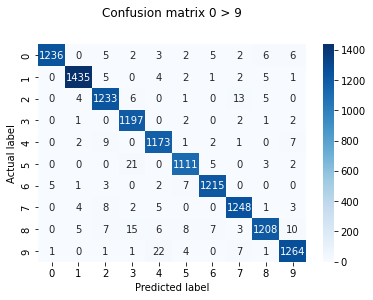

In [23]:
cm = confusion_matrix(y_pred, y_test)

p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix 0 > 9', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

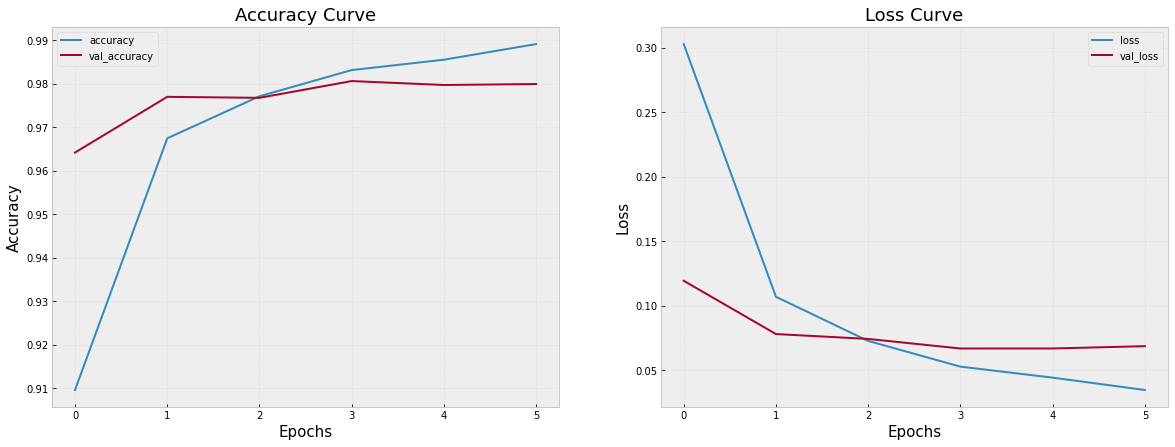

In [24]:
plt.style.use('bmh')
%matplotlib inline

f = plt.figure(figsize=(20,7))

# plot accuracy
f.add_subplot(121)

plt.plot(history.epoch,history.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history.epoch,history.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# plot loss
f.add_subplot(122)

plt.plot(history.epoch,history.history['loss'],label="loss") # Loss curve for training set
plt.plot(history.epoch,history.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

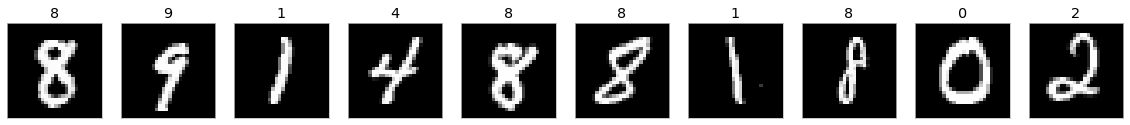

In [25]:
# predictions
fig, axes = plt.subplots(ncols=10, sharex=False,
                         sharey=True, figsize=(20, 4))
for i in range(10):
    axes[i].set_title(y_pred[i])
    axes[i].imshow(X_test[i], cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.show()

In [46]:
from tensorflow.keras.models import save_model, load_model

In [47]:
save_model(model,'model.h5')